In [ ]:
#https://github.com/akshaychawla/Occlusion-experiments-for-image-segmentation/blob/master/Occlusion%20experiments%20for%20segmentation.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import json
from copy import deepcopy
#from scipy.misc import imresize, imsave
from PIL import Image

In [2]:
from nnet.vgg16 import VGG16
from keras.preprocessing import image
from nnet.imagenet_utils import preprocess_input, decode_predictions

In [3]:
def reformat(input):
    x=np.zeros((len(input), 3, 224, 224))
    for i in xrange(len(input)):
        x[i,0,:,:] = input[i][:,:,0]
        x[i,1,:,:] = input[i][:,:,1]
        x[i,2,:,:] = input[i][:,:,2]
    
    return x

In [4]:
class OcclusionGenerator(object):
    def __init__(self, img, boxsize=10, step=10, prepocess=True):
        self.img=img
        self.boxsize=boxsize
        self.step=step
        self.i=0
        self.j=0
    
    def flow(self):
        '''Return a single occluded image and its location'''
        if self.i + self.boxsize >  self.img.shape[0]:
            return None,None,None
        retImg = np.copy(self.img)
        retImg[self.i:self.i+self.boxsize, self.j:self.j+self.boxsize] = 0.0
          
        old_i = deepcopy(self.i)
        old_j = deepcopy(self.j)
            
        self.j = self.j+self.step
        if self.j+self.boxsize > self.img.shape[1]:
            self.j = 0
            self.i = self.i + self.step
            
        return retImg, old_i, old_j
    
    def gen_minibatch(self, batchsize=10):
        
        '''return a minibatch of images of size <= batchsize'''
        occ_imlist = []
        locations = []
        for i in xrange(batchsize):
            occimg, i, j = self.flow()
            if occimg is not None:
                occ_imlist.append(occimg)
                locations.append([i,j])
        if len(occ_imlist) == 0: #no data
            return None, None
        else:
            #convert list to numpy array and pre-process input(0 mean centering)
            x = preprocess_input(reformat(occ_imlist))
            return x, locations

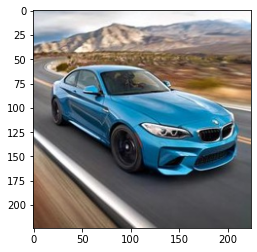

In [5]:
_img = Image.open("./images/car.jpeg")
img = np.array(_img.resize((224,224)))
plt.imshow(img)
occ = OcclusionGenerator(img,40,10, False)
occList = []

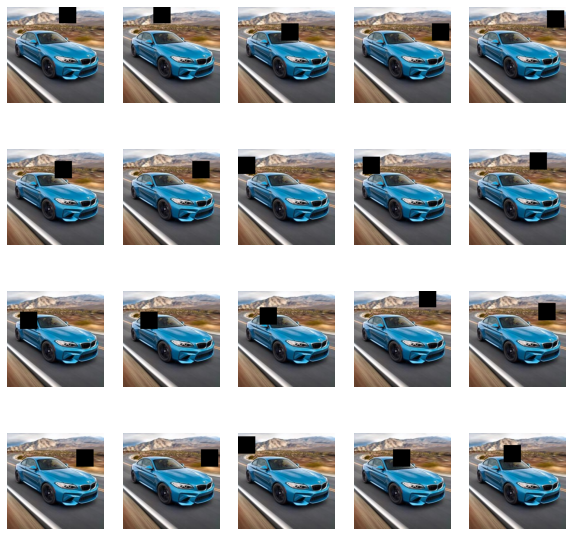

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,10)

for i in range(100):
    occList.append(occ.flow()[0])
    
for j in range(20):
    plt.subplot(4,5,j+1)
    plt.imshow(occList[np.random.randint(len(occList))]); plt.axis("off")

plt.show()
del occ, img, occList

In [7]:
#generate the heatmap for the given image location
def gen_heatmap(fileloc, boxsize, step, verbose=True, savetodisk=False):
    
    #load up image
    #img = mpimage.imread(fileloc)
    _img = Image.open(fileloc)
    img = np.array(_img.resize((224,224)))
    if verbose:
        plt.imshow(img); plt.axis("off")
        plt.show()
    
    model = VGG16(weights='imagenet')
    x = reformat([img])
    x = preprocess_input(x)
    preds = model.predict(x)
    correct_class_index = np.argmax(preds[0])
    
    #loda correct label text
    f = open("imagenet_class_index.json","rt")
    imagenet_labels = json.load(f)
    f.close()
    correct_class_label = imagenet_labels[str(correct_class_index)][1]
    if verbose:
        print(correct_class_label)
    
    #generate occluded images and location of mask
    occ = OcclusionGenerator(img, boxsize, step, True)
    
    #scores of occlusion image
    heatmap = []
    index = 0
    while True:
        #get minibatch of data
        x, locations = occ.gen_minibatch(batchsize=10)
        
        if x is not None:
            #predict
            op = model.predict(x)
            
            #unpack prediction values
            for i in range(x.shape[0]):
                score = op[i][correct_class_index]
                r,c = locations[i]
                scoremap = np.zeros((224, 224))
                scoremap[r: r+occ.boxsize, c: c+occ.boxsize] = score
                heatmap.append(scoremap)
            
            if verbose:
                print('..minibatch completed')
        else:
            break
            
    if savetodisk:
        #save heatmap to dist
        import cPickle as pickle
        f = open("heatmap", 'wb')
        pickle.dump(heatmap, f)
        f.close()
    
    return heatmap, correct_class_index, correct_class_label      
                

In [8]:
#run the program on image of a golden retri
heatmapList, index, label = gen_heatmap("./images/golden_retriever.jpeg", 20, 10, False)
processed = post_process(heatmapList)

553467904/553466928 [==============================] - 370s 1us/step


ValueError: Shapes (3, 3, 224, 64) and (3, 3, 64, 3) are incompatible